# EDA performed on about three days worth of CC-NEWS articles from 4-7 March 2021

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from urllib import parse
from collections import Counter
import requests
from io import StringIO

import spacy
from spacy import displacy
import nltk

# download nltk models
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/xmiles/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /home/xmiles/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /home/xmiles/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [2]:
articles = pd.read_csv('cc-nz-articles-test.csv')

articles['Datetime'] = pd.to_datetime(articles['Datetime'], format="%Y-%m-%dT%H:%M:%SZ")

In [3]:
print(f"Start datetime: {articles['Datetime'].iloc[0]}\n"
      f"End datetime:   {articles['Datetime'].iloc[-1]}")

Start datetime: 2021-03-04 01:13:28
End datetime:   2021-03-07 00:39:33


In [4]:
articles['Words'] = [re.findall(r"[\w']+", text_i) for text_i in articles['Text']]

In [5]:
def get_less_mask(less_limit):
    return [len(words) < less_limit for words in articles['Words']]

def get_more_mask(more_limit):
    return [len(words) > more_limit for words in articles['Words']]
    
    
for x in [10, 20, 50, 100]:
    less_mask = get_less_mask(x)
    print(f"There is {len(articles[less_mask]): >3} articles with less than {x: >3} words.")
    
    
print(f"\nThere is {len(articles)} total articles.")

There is   8 articles with less than  10 words.
There is 139 articles with less than  20 words.
There is 188 articles with less than  50 words.
There is 330 articles with less than 100 words.

There is 1709 total articles.


In [6]:
articles['num_words'] = [len(x) for x in articles['Words']]

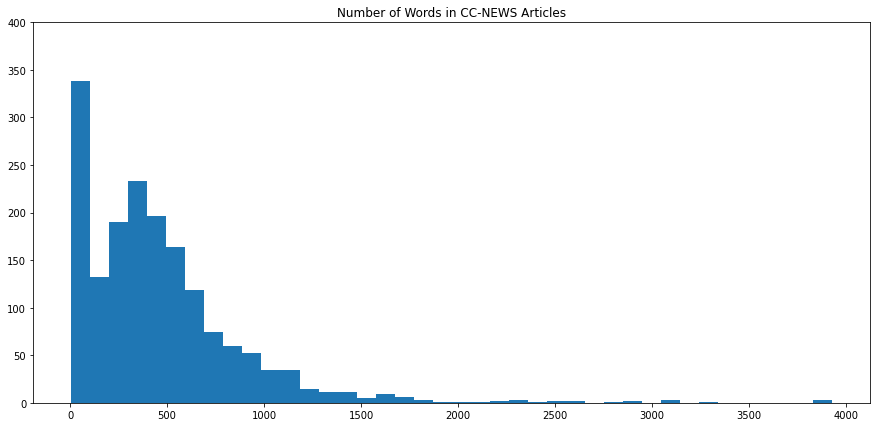

In [7]:
fig, ax = plt.subplots(figsize=(15, 7));
ax.hist(articles['num_words'], bins=40)
ax.set(ylim=(0, 400), title="Number of Words in CC-NEWS Articles");

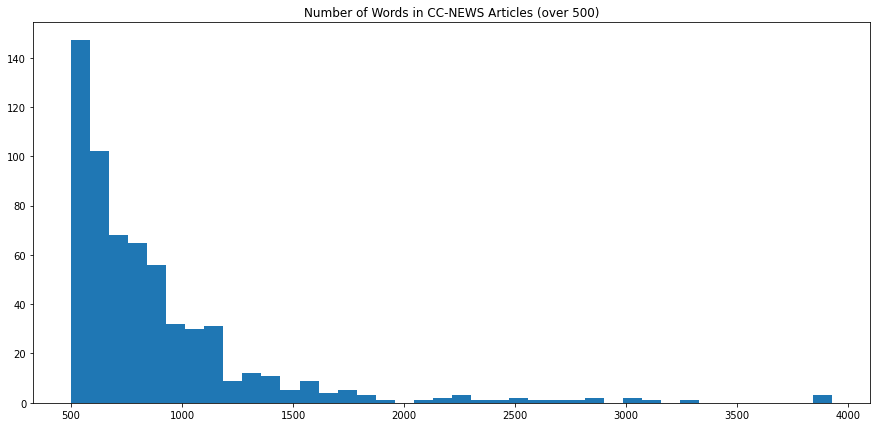

In [8]:
fig, ax = plt.subplots(figsize=(15, 7));
ax.hist(articles[articles['num_words'] > 500]['num_words'], bins=40)
ax.set(title="Number of Words in CC-NEWS Articles (over 500)");

In [9]:
def get_site_name(url):
    netloc = parse.urlsplit(url).netloc
    basename = netloc.replace('www.', '').replace('.nz', '').replace('.co', '').replace('.org', '')
    return basename

# Get names of news site
articles['news_site'] = articles['URL'].map(get_site_name)

In [10]:
articles['news_site'].unique()

array(['nzherald', 'asiapacificreport', 'tvnz', 'auckland.scoop', 'voxy',
       'stuff', 'driven', 'thespinoff', 'business.scoop',
       'wellington.scoop', 'scoop', 'philips', 'reseller', 'horsetalk',
       'werewolf', 'odt', 'futurefive', 'pressf1.pcworld', 'nzcatholic',
       'kanivatonga', 'pacific.scoop', 'viva', 'rdu', 'capitalmag',
       'oamarumail', 'pr', 'cathnews', 'infonews'], dtype=object)

In [11]:
def plot_num_articles_per_subgroup(subgroup_column, title="", num_subgroups=None):
    """
    If the number of subgroups is not specified, then it will display all of them.
    """
    subgroup_counts = Counter(articles[subgroup_column]).most_common()
    if num_subgroups is None:
        num_subgroups = len(subgroup_counts)
        
    names = [info[0] for info in subgroup_counts[:num_subgroups]][::-1]
    counts = [info[1] for info in subgroup_counts[:num_subgroups]][::-1]

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.barh(names, counts)
    ax.set(title=title)
    plt.show();

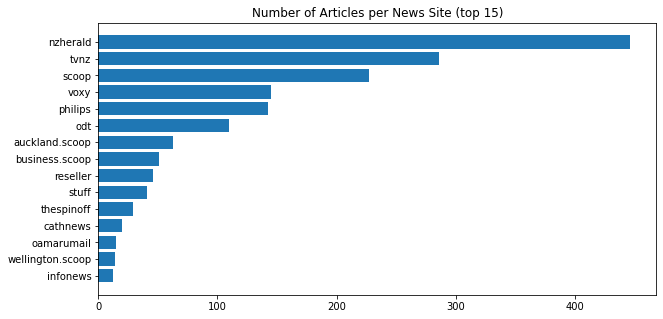

In [12]:
plot_num_articles_per_subgroup("news_site", title="Number of Articles per News Site (top 15)", num_subgroups=15)

In [13]:
def plot_num_words_per_subgroup(subgroup_column):
    """
    Displays top 10 subgroups.
    """
    subgroup_counts = Counter(articles[subgroup_column]).most_common()
        
    names = [info[0] for info in subgroup_counts[:10]][::-1]
    counts = [info[1] for info in subgroup_counts[:10]][::-1]
    
    fig, axes = plt.subplots(5, 2, figsize=(20, 20))
    ax = axes.ravel()
    i = len(ax)

    for i, axi in enumerate(ax[::-1]):
        articlesi = articles[articles[subgroup_column] == names[i]]
        axi.hist(articlesi['num_words'], bins=15)
        axi.set(title=f"Number of words for {names[i]} ({counts[i]} articles)")

    plt.show();

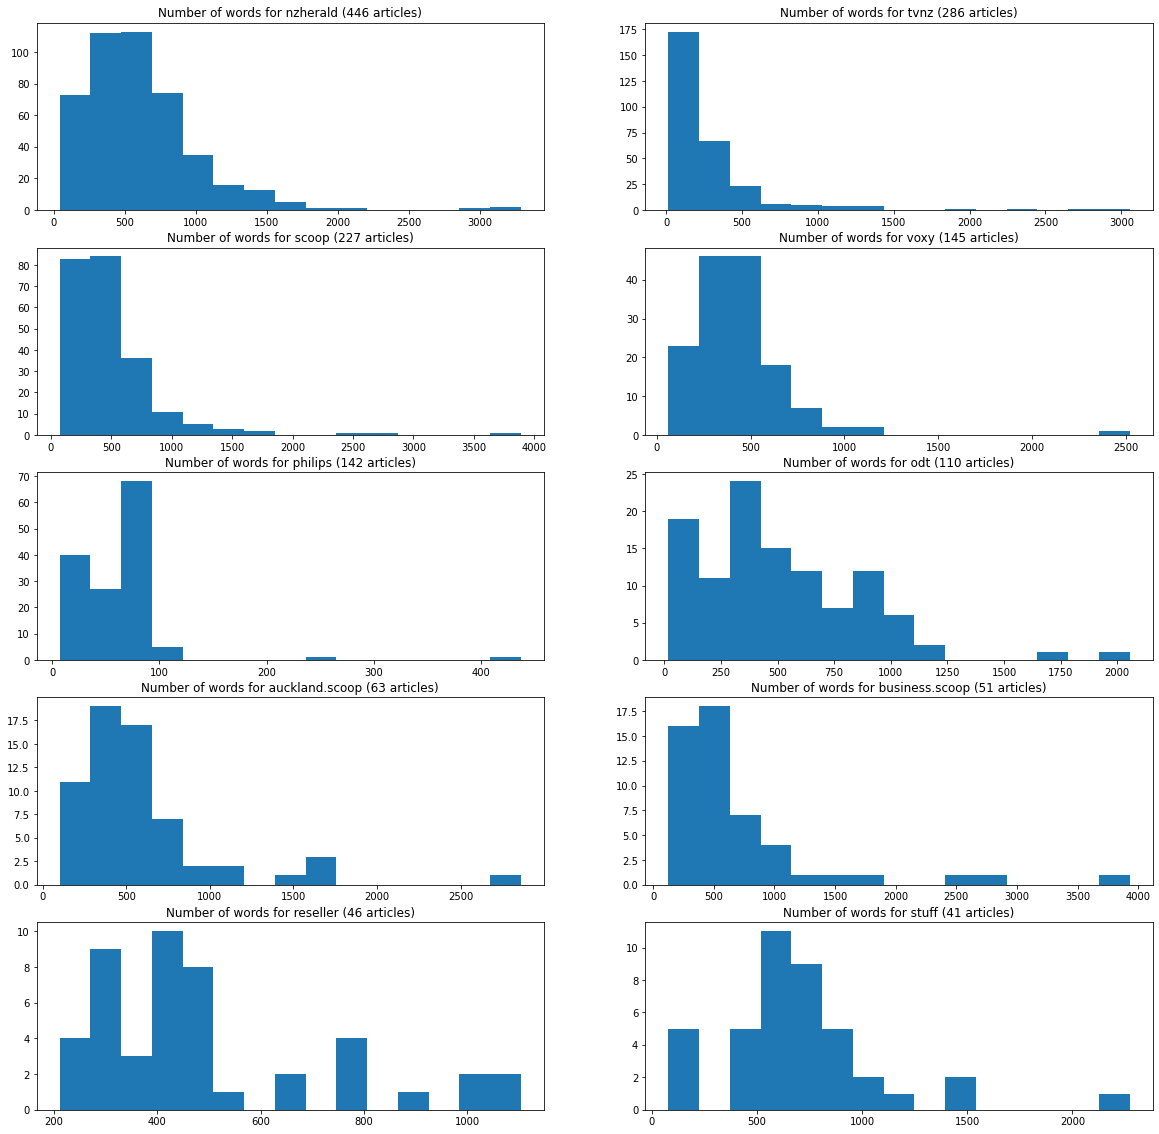

In [14]:
plot_num_words_per_subgroup("news_site")

## There is multiple sub-websites under the 'scoop' umbrella - maybe should group these together?

In [15]:
scoop_mask = articles['news_site'].str.contains("scoop")

print("Scoop sub-websites:")
scoop_websites = articles[scoop_mask]['news_site'].unique()
for website in scoop_websites:
    num_articles = np.sum(articles['news_site'] == website)
    print(f"{website: <25}| {num_articles}")

Scoop sub-websites:
auckland.scoop           | 63
business.scoop           | 51
wellington.scoop         | 14
scoop                    | 227
pacific.scoop            | 7


In [16]:
# create new column which groups all the scoop websites together
articles['news_site_scoop'] = np.where(articles['news_site'].isin(scoop_websites), "scoop (all)", articles['news_site'])

# check it has worked
articles[articles['news_site_scoop'] == "scoop (all)"].head(20)

,Datetime,URL,Text,Words,num_words,news_site,news_site_scoop
28,2021-03-04 02:20:23,http://auckland.scoop.co.nz/2021/03/aaf-2021-s...,Press Release – Auckland Arts Festival\n\nAuck...,"[Press, Release, Auckland, Arts, Festival, Auc...",357,auckland.scoop,scoop (all)
29,2021-03-04 02:20:28,http://auckland.scoop.co.nz/2021/03/cancellati...,Press Release – Surf Life Saving New Zealand\n...,"[Press, Release, Surf, Life, Saving, New, Zeal...",735,auckland.scoop,scoop (all)
30,2021-03-04 02:20:34,http://auckland.scoop.co.nz/2021/03/mapura-stu...,Press Release – Mapura Studios\n\nFollowing th...,"[Press, Release, Mapura, Studios, Following, t...",541,auckland.scoop,scoop (all)
31,2021-03-04 02:20:40,http://auckland.scoop.co.nz/2021/03/soul-sessi...,Press Release – ecg\n\nIt’s a landmark occasio...,"[Press, Release, ecg, It, s, a, landmark, occa...",596,auckland.scoop,scoop (all)
46,2021-03-04 02:46:07,http://auckland.scoop.co.nz/2021/03/covid-no-d...,Press Release – University of Auckland\n\nCovi...,"[Press, Release, University, of, Auckland, Cov...",373,auckland.scoop,scoop (all)
47,2021-03-04 02:46:12,http://auckland.scoop.co.nz/2021/03/due-to-the...,Press Release – Genius Generation\n\nThere has...,"[Press, Release, Genius, Generation, There, ha...",350,auckland.scoop,scoop (all)
48,2021-03-04 02:46:18,http://auckland.scoop.co.nz/2021/03/new-zealan...,Press Release – WTCF\n\nAuckland couple launch...,"[Press, Release, WTCF, Auckland, couple, launc...",548,auckland.scoop,scoop (all)
49,2021-03-04 02:46:23,http://auckland.scoop.co.nz/2021/03/over-350-e...,Press Release – Neighbours Day\n\nCommunities ...,"[Press, Release, Neighbours, Day, Communities,...",1588,auckland.scoop,scoop (all)
50,2021-03-04 02:46:29,http://auckland.scoop.co.nz/2021/03/seven-new-...,"Press Release – IDC\n\nAUCKLAND, New Zealand, ...","[Press, Release, IDC, AUCKLAND, New, Zealand, ...",1726,auckland.scoop,scoop (all)
51,2021-03-04 02:46:35,http://auckland.scoop.co.nz/2021/03/university...,"‘Cultivating resilience, changing the world’ w...","[Cultivating, resilience, changing, the, world...",562,auckland.scoop,scoop (all)


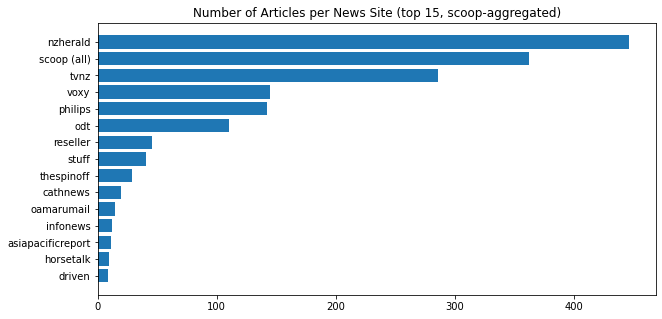

In [17]:
plot_num_articles_per_subgroup("news_site_scoop", title="Number of Articles per News Site (top 15, scoop-aggregated)", num_subgroups=15)

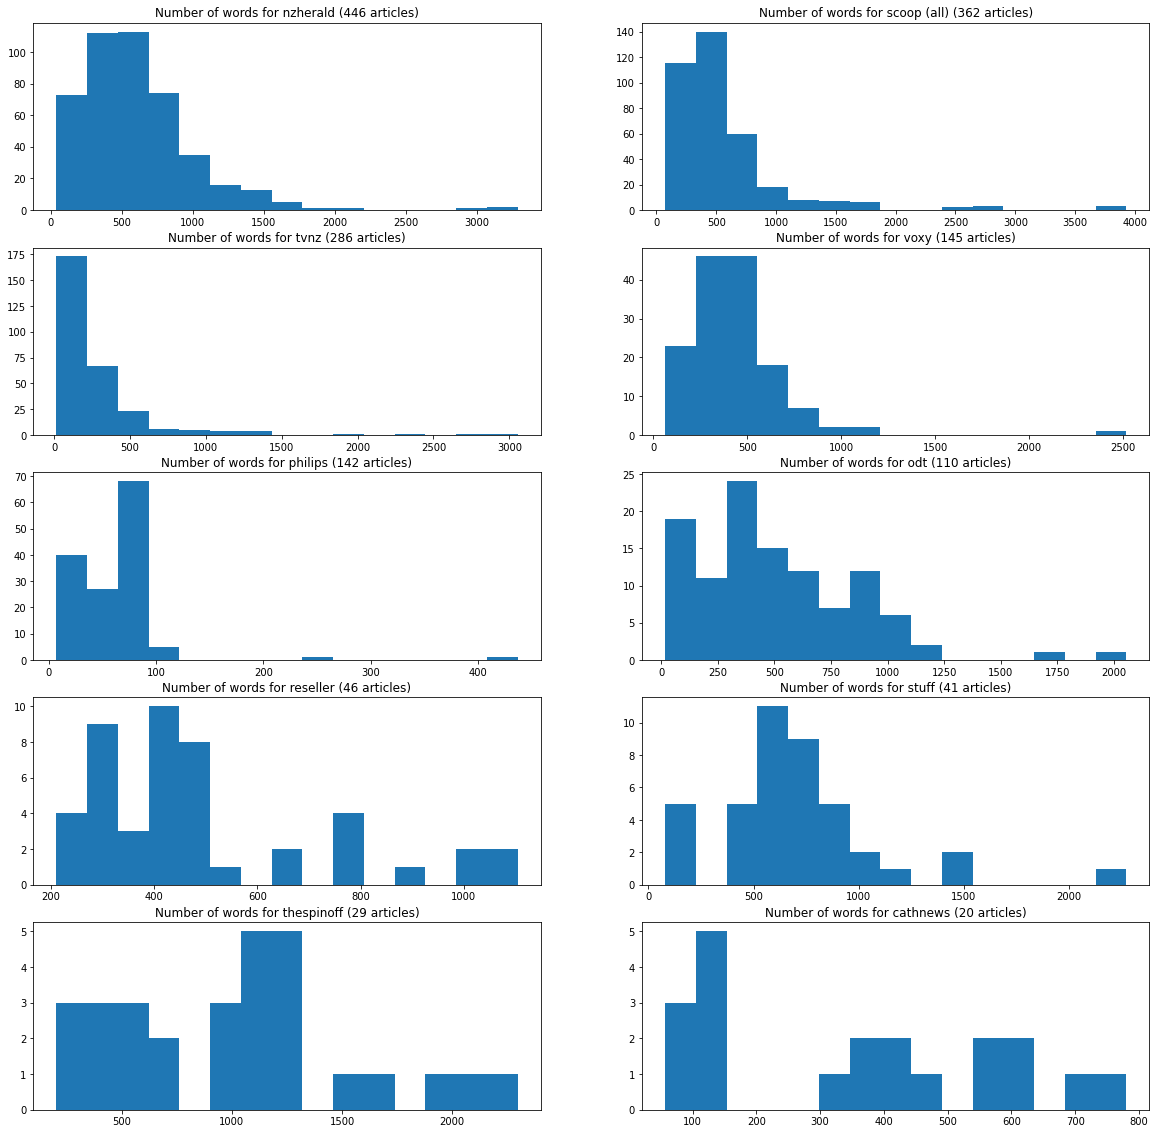

In [18]:
plot_num_words_per_subgroup("news_site_scoop")

In [19]:
for x in articles.loc[:100, 'URL']: print(x)

https://www.nzherald.co.nz/bay-of-plenty-times/news/grieving-whangamata-mum-helps-community-after-sons-death/N3KNWWR373DW2QQGLZ5ZHOK4AU/
https://www.nzherald.co.nz/bay-of-plenty-times/news/serious-injuries-in-crash-on-state-highway-30-whakatane/Q4TWNGVZ4K7HWKXGS3PRDSY4XE/
https://www.nzherald.co.nz/business/internet-traffic-hits-second-highest-peak-but-its-not-the-lockdown/6XB3QAECYECTZGK6OYOENOAH3E/
https://www.nzherald.co.nz/hawkes-bay-today/news/damage-to-dannevirkes-iconic-carnegie-building-concerns-board/X6HHRP7TTGIYMIJ7N2FCXRCJK4/
https://www.nzherald.co.nz/hawkes-bay-today/news/rescue-helicopter-open-day-postponed/ARDMZFIET5OCM2M3SCQZYVJCJI/
https://www.nzherald.co.nz/whanganui-chronicle/news/hundreds-of-homes-across-rangitikei-region-without-power/MHA6J47GYILQLJNLC4UD3U4SWI/
https://www.nzherald.co.nz/nz/wanted-sean-broderick-still-on-the-run-could-be-anywhere/FY5XMLB2SGH3MYJOH47BIUMH6Q/
https://www.nzherald.co.nz/the-country/news/prison-inmates-in-south-otago-skill-up-on-dairy

## Location Extraction #1: simple string search

This searches the text in the articles, but maybe it could be used along with searching the URLs.

In [20]:
# https://en.wikipedia.org/wiki/List_of_cities_in_New_Zealand
top_20_cities = [
    "Auckland", "Christchurch", "Wellington", "Hamilton", "Tauranga",
    "Lower Hutt", "Dunedin", "Palmerston North", "Napier", "Hibiscus Coast",
    "Porirua", "Rotorua", "New Plymouth", "Whangarei", "Nelson", "Invercargill",
    "Hastings", "Upper Hutt", "Whanaganui", "Gisborne"
]
# https://en.wikipedia.org/wiki/Regions_of_New_Zealand
regions = [
    "Northland", "Auckland", "Waikato", "Bay of Plenty", "Gisborne", 
    "Hawke's Bay", "Taranaki", "Manawatu-Whanganui", "Wellington", "Tasman",
    "Nelson", "Marlborough", "West Coast", "Canterbury", "Otago", "Southland"
]
# use set to remove duplicates
# proper_place_names = sorted(list(set(top_20_cities + regions)))
        
# place_names = ['-'.join(name.split(' ')).lower() if ' ' in name 
#                else name.lower()
#                for name in proper_place_names]

# URL gives the top 100 cities by population
url = "https://simplemaps.com/static/data/country-cities/nz/nz.csv"
with requests.get(url, stream=True) as r:
    csv_stringio = StringIO(r.content.decode('utf-8'))
    nz_cities = pd.read_csv(csv_stringio)
    
nz_cities = nz_cities[nz_cities['admin_name'] != 'Chatham Islands']  # remove Chatham Islands as small population

city_to_region = {city: region for city, region in zip(nz_cities['city'], nz_cities['admin_name'])}
# Construct list of all place names including cities and regions
place_names = list(set(city_to_region.keys()) | set(city_to_region.values()))

print("City-to-region dictionary:")
print(city_to_region)
print()
print("Regions:")
print(nz_cities['admin_name'].unique().tolist())
# !!should handle accents eg Whangarei vs. Whangārei, Manawatu-Whanganui vs. Manawatū-Whanganui

City-to-region dictionary:
{'Auckland': 'Auckland', 'Wellington': 'Wellington', 'Christchurch': 'Canterbury', 'Manukau City': 'Auckland', 'Waitakere': 'Auckland', 'Northcote': 'Auckland', 'Hamilton': 'Waikato', 'Tauranga': 'Bay of Plenty', 'Dunedin': 'Otago', 'Lower Hutt': 'Wellington', 'Palmerston North': 'Manawatu-Wanganui', 'Napier': 'Hawke’s Bay', 'Porirua': 'Wellington', 'New Plymouth': 'Taranaki', 'Rotorua': 'Bay of Plenty', 'Whangarei': 'Northland', 'Nelson': 'Nelson', 'Invercargill': 'Southland', 'Upper Hutt': 'Wellington', 'Whanganui': 'Manawatu-Wanganui', 'Gisborne': 'Gisborne', 'Paraparaumu': 'Wellington', 'Timaru': 'Canterbury', 'Blenheim': 'Marlborough', 'Pukekohe East': 'Auckland', 'Taupo': 'Waikato', 'Masterton': 'Wellington', 'Cambridge': 'Waikato', 'Levin': 'Manawatu-Wanganui', 'Ashton': 'Canterbury', 'Macetown': 'Otago', 'Feilding': 'Manawatu-Wanganui', 'Rolleston': 'Canterbury', 'Whakatane': 'Bay of Plenty', 'Richmond': 'Tasman', 'Havelock North': 'Hawke’s Bay', 'Tok

In [21]:
%%time
names_joined = '|'.join(place_names)
articles['locations_str'] = [re.findall(names_joined, text) for text in articles['Text']]

CPU times: user 187 ms, sys: 2.96 ms, total: 190 ms
Wall time: 188 ms


In [22]:
no_locations_str_mask = [len(x) == 0 for x in articles['locations_str']]

print("No locations:")
print(articles[no_locations_str_mask].shape[0])
print("No locations and more than 20 words:")
print(articles[np.logical_and(no_locations_str_mask, get_more_mask(20))].shape[0])
print("No locations and more than 50 words:")
print(articles[np.logical_and(no_locations_str_mask, get_more_mask(50))].shape[0])

No locations:
770
No locations and more than 20 words:
630
No locations and more than 50 words:
584


## Location Extraction #2: spaCy package

__spaCy reognises the following entities:__
- PERSON:      People, including fictional.
- NORP:        Nationalities or religious or political groups.
- FAC:         Buildings, airports, highways, bridges, etc.
- ORG:         Companies, agencies, institutions, etc.
- GPE:         Countries, cities, states.
- LOC:         Non-GPE locations, mountain ranges, bodies of water.
- PRODUCT:     Objects, vehicles, foods, etc. (Not services.)
- EVENT:       Named hurricanes, battles, wars, sports events, etc.
- WORK_OF_ART: Titles of books, songs, etc.
- LAW:         Named documents made into laws.
- LANGUAGE:    Any named language.
- DATE:        Absolute or relative dates or periods.
- TIME:        Times smaller than a day.
- PERCENT:     Percentage, including ”%“.
- MONEY:       Monetary values, including unit.
- QUANTITY:    Measurements, as of weight or distance.
- ORDINAL:     “first”, “second”, etc.
- CARDINAL:    Numerals that do not fall under another type.

In [23]:
nlp = spacy.load("en_core_web_sm")
# ent.label_=="GPE" is detected ENTities which are locations

def get_spacy_locations(text, nlp):
    return [ent.text for ent in nlp(text).ents if ent.label_ in ["GPE"]]

zebra = [
    get_spacy_locations(article, nlp)
    for article in articles['Text'][:10]
]
                         
for x in zebra: print(x)

['Kristan', 'New Zealand', 'Hauraki', 'Port Rd']
['Thornton', 'Thornton Rd']
['Spark Sport', 'NZ', 'Australia', 'Australia']
['Allardice', 'Allardice', 'New Zealand', 'Wimbledon', 'Herbertville']
[]
['Hunterville', 'Hunterville', 'Feilding', 'Halcombe Rd']
[]
['Milburn', 'Milburn', 'Milton']
['Oceania']
['Bendigo', 'Argentina', 'Bendigo']


In [24]:
%%time
articles['locations_spacy'] = [get_spacy_locations(text, nlp) for text in articles['Text']]

CPU times: user 1min 59s, sys: 1.78 s, total: 2min 1s
Wall time: 2min 1s


In [25]:
no_locations_spacy_mask = [len(x) == 0 for x in articles['locations_spacy']]

print("No locations:")
print(articles[no_locations_spacy_mask].shape[0])
print("No locations and more than 20 words:")
print(articles[np.logical_and(no_locations_spacy_mask, get_more_mask(20))].shape[0])
print("No locations and more than 50 words:")
print(articles[np.logical_and(no_locations_spacy_mask, get_more_mask(50))].shape[0])

No locations:
460
No locations and more than 20 words:
320
No locations and more than 50 words:
277


## Location Extraction #3: nltk package

In [26]:
# source: https://gist.github.com/onyxfish/322906
def extract_entity_names(t):
    entity_names = []

    if hasattr(t, 'label') and t.label:
        if t.label() == 'NE':
            entity_names.append(' '.join([child[0] for child in t]))
        else:
            for child in t:
                entity_names.extend(extract_entity_names(child))

    return entity_names


def get_locations_nltk(text):

    sentences = nltk.sent_tokenize(text)
    tokenized_sentences = [nltk.word_tokenize(sentence) for sentence in sentences]
    tagged_sentences = [nltk.pos_tag(sentence) for sentence in tokenized_sentences]
    chunked_sentences = nltk.ne_chunk_sents(tagged_sentences, binary=True)

    entities = []
    for tree in chunked_sentences:
        entities.extend(extract_entity_names(tree))

    return entities

# [loc in loc_nltk 
#  for loc in loc_str 
#  for loc_str, loc_nltk in articles[['locations_str', 'locations_nltk']]]

In [27]:
%%time
articles['locations_nltk'] = articles['Text'].map(get_locations_nltk)

CPU times: user 1min 38s, sys: 221 ms, total: 1min 38s
Wall time: 1min 38s


In [28]:
no_locations_nltk_mask = [len(x) == 0 for x in articles['locations_nltk']]

print("No locations:")
print(articles[no_locations_nltk_mask].shape[0])
print("No locations and more than 20 words:")
print(articles[np.logical_and(no_locations_nltk_mask, get_more_mask(20))].shape[0])
print("No locations and more than 50 words:")
print(articles[np.logical_and(no_locations_nltk_mask, get_more_mask(50))].shape[0])

No locations:
6
No locations and more than 20 words:
4
No locations and more than 50 words:
3


__Note that the nltk extraction method seems to pick up all "Named Entities" not just Locations, so further refinement/filtering is required afterwards.__

## Investigate the difference between location-extraction methods

It seems like string search might be sufficiently accurate if there is a large enough collection of place names, along with a dictionary mapping the cities/towns to regions. The string search also seems like the fastest option and most predictable option.

It could be made more powerful by first searching the URL strings e.g. any article with URL www.nzherald.co.nz/bay-of-plenty-times/... should be assigned to Bay of Plenty region. This could be quick as the unique number of places in URLs would be small as there is a limited number of news publications.

In [29]:
# See which locations are in all searches (intersection of three columns)
articles['locations_all'] = [list(set(x[0]) & set(x[1]) & set(x[2])) for x in zip(articles['locations_str'], articles['locations_spacy'], articles['locations_nltk'])]

In [30]:
articles.head()

,Datetime,URL,Text,Words,num_words,news_site,news_site_scoop,locations_str,locations_spacy,locations_nltk,locations_all
0,2021-03-04 01:13:28,https://www.nzherald.co.nz/bay-of-plenty-times...,Sixteen-year-old Virgil Lopes of Whangamata. P...,"[Sixteen, year, old, Virgil, Lopes, of, Whanga...",956,nzherald,nzherald,"[Whangamata, Whangamata, Whangamata, Whangamat...","[Kristan, New Zealand, Hauraki, Port Rd]","[Virgil Lopes, Whangamata, Photo, Virgil, Kris...",[]
1,2021-03-04 01:13:35,https://www.nzherald.co.nz/bay-of-plenty-times...,FILE\n\nTwo people are seriously injured after...,"[FILE, Two, people, are, seriously, injured, a...",166,nzherald,nzherald,"[Whakatane, Waikato, Whakatane]","[Thornton, Thornton Rd]","[Whakatāne, Thornton, Paroa Rds, SH30, Whakata...",[]
2,2021-03-04 01:13:40,https://www.nzherald.co.nz/business/internet-t...,Image / 123rf\n\nInternet traffic on Chorus' n...,"[Image, 123rf, Internet, traffic, on, Chorus',...",321,nzherald,nzherald,[Auckland],"[Spark Sport, NZ, Australia, Australia]","[Image, Chorus, Duty, Spark Sport, Chorus, NZ,...",[]
3,2021-03-04 01:13:45,https://www.nzherald.co.nz/hawkes-bay-today/ne...,Smashed windows on the Carnegie building in Al...,"[Smashed, windows, on, the, Carnegie, building...",667,nzherald,nzherald,[],"[Allardice, Allardice, New Zealand, Wimbledon,...","[Carnegie, Dannevirke Community Board, Photo, ...",[]
4,2021-03-04 01:13:51,https://www.nzherald.co.nz/hawkes-bay-today/ne...,The Palmerston North Rescue Helicopter in flig...,"[The, Palmerston, North, Rescue, Helicopter, i...",306,nzherald,nzherald,"[Palmerston North, Palmerston North, Palmersto...",[],"[Palmerston North Rescue Helicopter, Photo, Pa...",[]


In [31]:
num_articles = articles.shape[0]
print(f"str locations:   {num_articles - articles[no_locations_str_mask].shape[0]} / {num_articles}")
print(f"spacy locations: {num_articles - articles[no_locations_spacy_mask].shape[0]} / {num_articles}")
print(f"nltk locations:  {num_articles - articles[no_locations_nltk_mask].shape[0]} / {num_articles}")

str locations:   939 / 1709
spacy locations: 1249 / 1709
nltk locations:  1703 / 1709


In [32]:
no_overlap_mask = [len(x) == 0 for x in articles['locations_all']]
print(f"Unanimous decision: {num_articles - articles[no_overlap_mask].shape[0]} / {num_articles}")

Unanimous decision: 505 / 1709


In [33]:
# nltk seems like the worst option, so see overlap between the other two methods
articles['locations_str_spacy'] = [list(set(x[0]) & set(x[1])) for x in zip(articles['locations_str'], articles['locations_spacy'])]
no_str_spacy_mask = [len(x) == 0 for x in articles['locations_str_spacy']]
print(f"Agreement between str and spacy: {num_articles - articles[no_str_spacy_mask].shape[0]} / {num_articles}")

Agreement between str and spacy: 522 / 1709


Seems like the exclusion of nltk makes marginal difference.

In [34]:
str_spacy_most_common = pd.Series([Counter(loc).most_common(1)[0][0] if len(loc) > 0 else None for loc in articles['locations_str_spacy']])

In [35]:
str_spacy_most_common[str_spacy_most_common.notnull()].head(20)

5       Feilding
20      Auckland
25      Auckland
29      Auckland
30      Auckland
32      Auckland
36      Auckland
37      Auckland
41    Wellington
47      Auckland
49     Northland
50      Auckland
52      Auckland
54    Wellington
56      Auckland
57      Auckland
58       Waikato
59      Auckland
66      Auckland
67      Auckland
dtype: object

## Mapping cities to regions

This way the information about the articles can be viewed region-by-region. Any unmapped cities/towns will not be made None.

Should investigate how much variation/disagreement there is depending on the region. FOR EXAMPLE: for a given 'main'/modal region, how many other regions are typically detected in the article?

In [36]:
%%time
articles['regions_str'] = [
    [city_to_region[loc] if loc in city_to_region.keys() else loc
     for loc in locs]
    for locs in articles['locations_str']
]

CPU times: user 3.59 ms, sys: 0 ns, total: 3.59 ms
Wall time: 4.9 ms


In [37]:
# for locs, regions in zip(articles['locations_str'], regions_str):
#     if len(locs) > 0:
#         print(locs, regions)

In [38]:
# take most common region
articles['regions_str_main'] = [Counter(regions).most_common(1)[0][0] if len(regions) > 0 else "Other"
                                for regions in articles['regions_str']]

In [39]:
articles.head()

,Datetime,URL,Text,Words,num_words,news_site,news_site_scoop,locations_str,locations_spacy,locations_nltk,locations_all,locations_str_spacy,regions_str,regions_str_main
0,2021-03-04 01:13:28,https://www.nzherald.co.nz/bay-of-plenty-times...,Sixteen-year-old Virgil Lopes of Whangamata. P...,"[Sixteen, year, old, Virgil, Lopes, of, Whanga...",956,nzherald,nzherald,"[Whangamata, Whangamata, Whangamata, Whangamat...","[Kristan, New Zealand, Hauraki, Port Rd]","[Virgil Lopes, Whangamata, Photo, Virgil, Kris...",[],[],"[Waikato, Waikato, Waikato, Waikato, Waikato, ...",Waikato
1,2021-03-04 01:13:35,https://www.nzherald.co.nz/bay-of-plenty-times...,FILE\n\nTwo people are seriously injured after...,"[FILE, Two, people, are, seriously, injured, a...",166,nzherald,nzherald,"[Whakatane, Waikato, Whakatane]","[Thornton, Thornton Rd]","[Whakatāne, Thornton, Paroa Rds, SH30, Whakata...",[],[],"[Bay of Plenty, Waikato, Bay of Plenty]",Bay of Plenty
2,2021-03-04 01:13:40,https://www.nzherald.co.nz/business/internet-t...,Image / 123rf\n\nInternet traffic on Chorus' n...,"[Image, 123rf, Internet, traffic, on, Chorus',...",321,nzherald,nzherald,[Auckland],"[Spark Sport, NZ, Australia, Australia]","[Image, Chorus, Duty, Spark Sport, Chorus, NZ,...",[],[],[Auckland],Auckland
3,2021-03-04 01:13:45,https://www.nzherald.co.nz/hawkes-bay-today/ne...,Smashed windows on the Carnegie building in Al...,"[Smashed, windows, on, the, Carnegie, building...",667,nzherald,nzherald,[],"[Allardice, Allardice, New Zealand, Wimbledon,...","[Carnegie, Dannevirke Community Board, Photo, ...",[],[],[],Other
4,2021-03-04 01:13:51,https://www.nzherald.co.nz/hawkes-bay-today/ne...,The Palmerston North Rescue Helicopter in flig...,"[The, Palmerston, North, Rescue, Helicopter, i...",306,nzherald,nzherald,"[Palmerston North, Palmerston North, Palmersto...",[],"[Palmerston North Rescue Helicopter, Photo, Pa...",[],[],"[Manawatu-Wanganui, Manawatu-Wanganui, Manawat...",Manawatu-Wanganui


In [40]:
%%time
# do the equivalent work for spacy
articles['regions_spacy'] = [
    [city_to_region[loc] if loc in city_to_region.keys() 
     else loc if loc in city_to_region.values() else None
     for loc in locs]
    for locs in articles['locations_spacy']
]

CPU times: user 22.3 ms, sys: 27 µs, total: 22.3 ms
Wall time: 21.4 ms


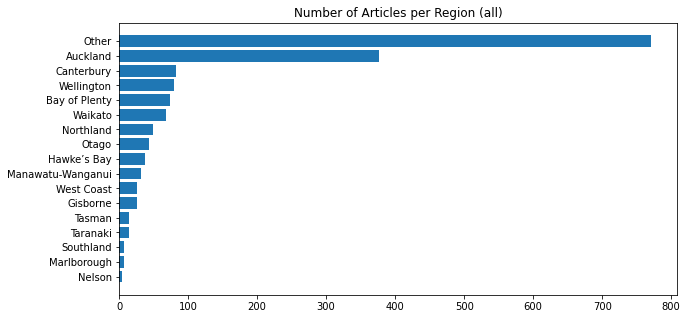

In [41]:
# look at information just using string search
plot_num_articles_per_subgroup('regions_str_main', title="Number of Articles per Region (all)")

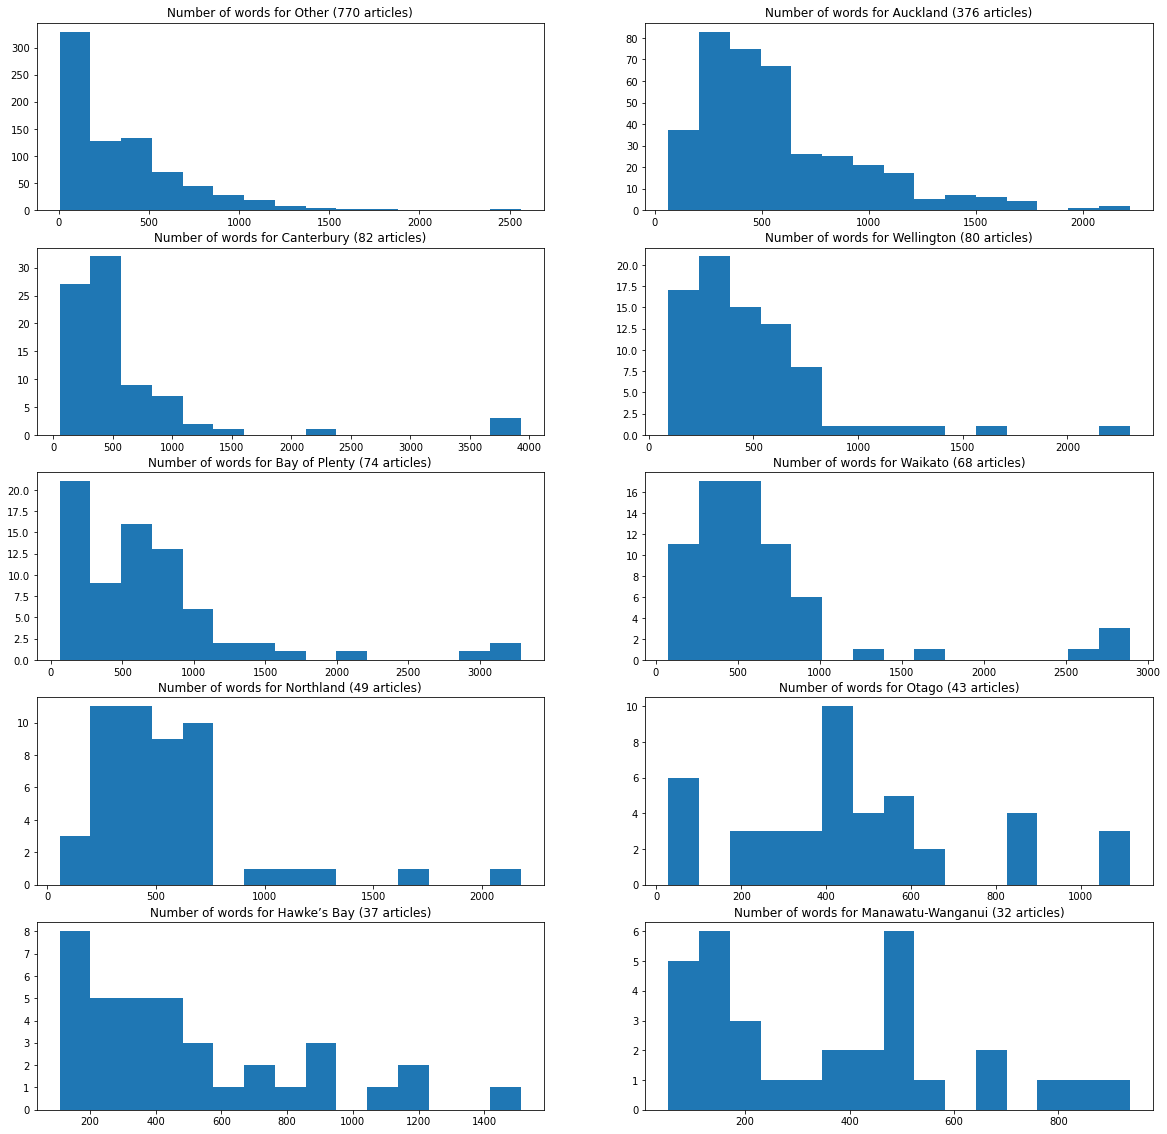

In [42]:
plot_num_words_per_subgroup('regions_str_main')

## Location Extraction #50: Check region selection

Check for any articles where there were multiple regions detected in the text, but no modal region was extracted.

In [43]:
yes_locations_str_mask = [len(x) > 0 for x in articles['locations_str']]
disagreement_mask = np.logical_and(yes_locations_str_mask,
                                   articles['regions_str_main'] == "Other")
articles[disagreement_mask][['URL', 'locations_str', 'regions_str', 'regions_str_main']]

,URL,locations_str,regions_str,regions_str_main


There is none which is good.

Maybe should see how many ties there are? FOR EXAMPLE: regions_str=['Auckland','Waikato','Waikato','Auckland'].

In [44]:
tie_mask = [Counter(regions).most_common(2)[0][1] == Counter(regions).most_common(2)[1][1] 
            if len(Counter(regions).most_common(2)) > 1 else False
            for regions in articles['regions_str']]

articles[tie_mask][['URL', 'locations_str', 'regions_str', 'regions_str_main']].head(30)

,URL,locations_str,regions_str,regions_str_main
66,https://www.nzherald.co.nz/hawkes-bay-today/ne...,"[Auckland, Napier]","[Auckland, Hawke’s Bay]",Auckland
70,https://www.nzherald.co.nz/whanganui-chronicle...,"[Whanganui, West Coast, Christchurch, West Coa...","[Manawatu-Wanganui, West Coast, Canterbury, We...",West Coast
115,https://www.scoop.co.nz/stories/HL2103/S00020/...,"[Auckland, Auckland, Northland, Whangarei, Auc...","[Auckland, Auckland, Northland, Northland, Auc...",Auckland
135,https://www.stuff.co.nz/business/124438249/gal...,"[Auckland, Auckland, Hamilton, Waikato]","[Auckland, Auckland, Waikato, Waikato]",Auckland
139,https://www.stuff.co.nz/business/industries/12...,"[Auckland, Canterbury]","[Auckland, Canterbury]",Auckland
156,https://www.reseller.co.nz/article/686615/capg...,"[Auckland, Wellington]","[Auckland, Wellington]",Auckland
188,http://www.voxy.co.nz/national/5/382854,"[Southland, Canterbury]","[Southland, Canterbury]",Southland
225,https://www.tvnz.co.nz/one-news/new-zealand/ki...,"[Gisborne, Kerikeri]","[Gisborne, Northland]",Gisborne
254,http://www.voxy.co.nz/business/5/382840,"[West Coast, Tasman, Marlborough, Otago, West ...","[West Coast, Tasman, Marlborough, Otago, West ...",West Coast
259,http://www.voxy.co.nz/business/5/382847,"[Waikato, Waikato, Bay of Plenty, Rotorua, Haw...","[Waikato, Waikato, Bay of Plenty, Bay of Plent...",Waikato


Some of these should be able to be resolved by parsing the URL for locations.

e.g. auckland.scoop.co.nz/... -> Auckland, www.nzherald.co.nz/hawkes-bay-today/... -> Hawke's Bay

## Location Extraction #51: URL parsing

Potential rules:
- auckland.scoop, wellington.scoop
- nzherald/bay-of-plenty-times, nzherald/hawkes-bay-today, nzherald/whanganui-chronicles